#  Dog vs Cat Image Classifier

**Project Overview:**  
This notebook implements a deep learning solution for binary image classification (dogs vs cats) using Convolutional Neural Networks (CNN).

**Key Highlights:**
- Custom CNN architecture with BatchNormalization
- Data augmentation for better generalization
- Achieves **81.07% accuracy** on test set
- Dataset: 25,000 images from Kaggle

**Author:** [Your Name]  
**Date:** February 2026  
**Technologies:** TensorFlow, Keras, Python

---

##  1. Import Libraries

We'll import all necessary libraries for:
- Data manipulation (NumPy, Pandas)
- Visualization (Matplotlib, Seaborn)
- Deep Learning (TensorFlow/Keras)
- Model evaluation (Scikit-learn)

In [144]:
import os
import random
import warnings
from warnings import filterwarnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

filterwarnings('ignore')

print("All libraries imported successfully!")

All libraries imported successfully!


##  2. Configuration & Hyperparameters

Setting up all configuration parameters in one place makes the code more maintainable and easier to experiment with different settings.

**Key Parameters:**
- Image size: 150x150 pixels (smaller size = faster training)
- Batch size: 128 (balance between speed and memory)
- Epochs: 20 (with early stopping)
- Random seed: 42 (for reproducibility)

In [145]:
IMAGE_WIDTH = 150
IMAGE_HEIGHT = 150
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3

BATCH_SIZE = 128
EPOCHS = 20

TEST_SIZE = 0.15     
VAL_SIZE = 0.1111    

BASE_PATH = '/kaggle/input/dog-and-cat-classification-dataset/PetImages'
MODEL_SAVE_PATH = 'model.weights.h5'

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

print("Configuration set!")

Configuration set!


##  3. Load Dataset

Loading images from the Kaggle Dogs vs Cats dataset.

**Dataset Structure:**
```
PetImages/
├── Cat/
│   ├── 0.jpg
│   ├── 1.jpg
│   └── ...
└── Dog/
    ├── 0.jpg
    ├── 1.jpg
    └── ...
```

**Label Encoding:**
- Cat = 1
- Dog = 0

In [146]:
filenames = []
categories = []

for category in ['Cat', 'Dog']:
    folder = os.path.join(BASE_PATH, category)
    for file in os.listdir(folder):
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            filenames.append(os.path.join(category, file))
            categories.append('1' if category == 'Cat' else '0')

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

print(f"Total images: {len(df)}")
print(f"Cats: {(df['category'] == '1').sum()}")
print(f"Dogs: {(df['category'] == '0').sum()}")

Total images: 24998
Cats: 12499
Dogs: 12499


##  4. Train/Validation/Test Split

Splitting the dataset into three sets:
- **Training (75%)**: Used to train the model
- **Validation (10%)**: Used to tune hyperparameters and monitor overfitting
- **Test (15%)**: Final evaluation of model performance

Using `stratify` to maintain class balance across all splits.

In [147]:
train_df, test_df = train_test_split(
    df, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_SEED, 
    stratify=df['category']
)

train_df, validate_df = train_test_split(
    train_df, 
    test_size=VAL_SIZE, 
    random_state=RANDOM_SEED, 
    stratify=train_df['category']
)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print(f"Training set: {len(train_df)} images")
print(f"Validation set: {len(validate_df)} images")
print(f"Test set: {len(test_df)} images")

Training set: 18887 images
Validation set: 2361 images
Test set: 3750 images


##  5. Exploratory Data Analysis (EDA)

Let's visualize our dataset to better understand what we're working with.

### 5.1 Class Distribution

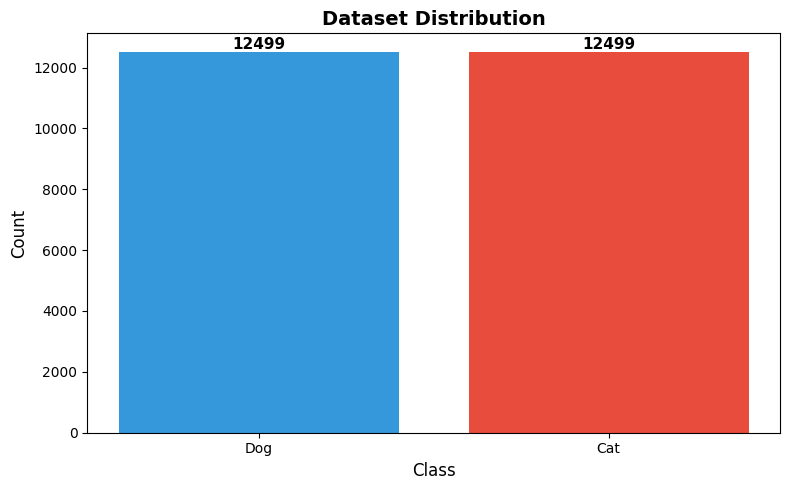

Dataset is well-balanced!


In [148]:
category_counts = df['category'].value_counts()

plt.figure(figsize=(8, 5))
labels = ['Dog', 'Cat']
colors = ['#3498db', '#e74c3c']
bars = plt.bar(labels, [category_counts['0'], category_counts['1']], color=colors)

plt.title('Dataset Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("Dataset is well-balanced!" if abs(category_counts['0'] - category_counts['1']) < 1000 else "Dataset has class imbalance")

### 5.2 Sample Images

Let's look at some random images from our dataset:

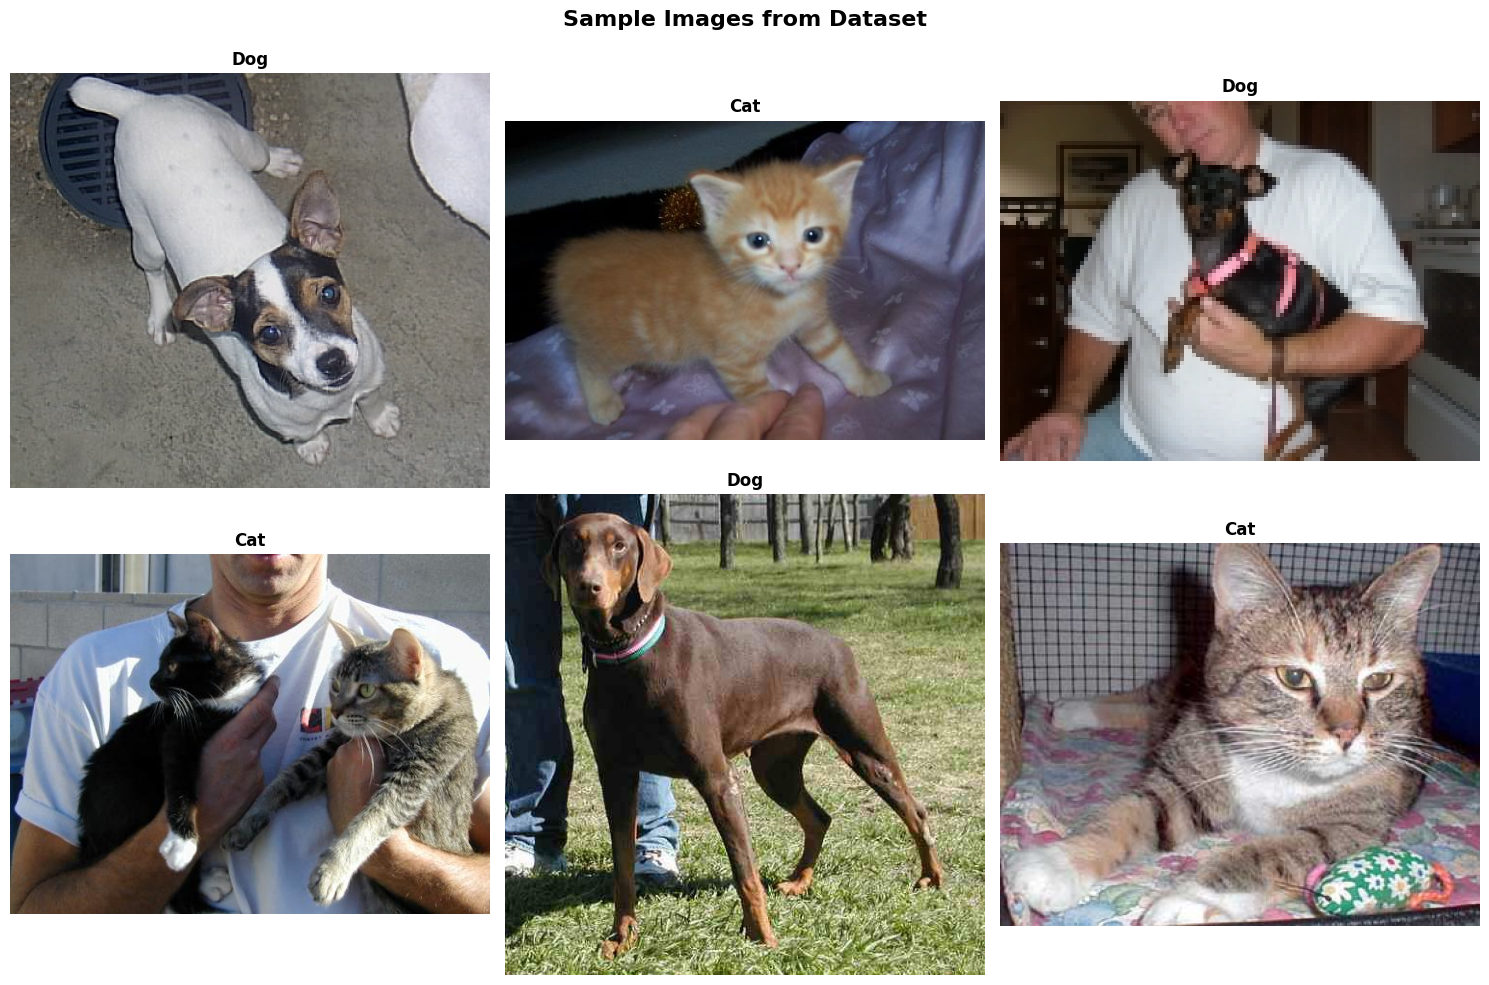

In [149]:
plt.figure(figsize=(15, 10))

samples = train_df.sample(n=6, random_state=RANDOM_SEED)

for idx, (_, row) in enumerate(samples.iterrows(), 1):
    filepath = os.path.join(BASE_PATH, row['filename'])
    image = load_img(filepath)
    label = 'Cat' if row['category'] == '1' else 'Dog'
    
    plt.subplot(2, 3, idx)
    plt.imshow(image)
    plt.title(f'{label}', fontsize=12, fontweight='bold')
    plt.axis('off')

plt.suptitle('Sample Images from Dataset', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

##  6. Data Augmentation

**Why Data Augmentation?**
- Increases effective dataset size
- Helps model generalize better
- Reduces overfitting

**Augmentation Techniques Applied:**
- Random rotation (±10°)
- Horizontal flipping
- Width/height shifting (±10%)
- Shear transformation (20%)
- Random zoom (20%)

**Important:** Augmentation is only applied to training data, not validation or test data!

In [150]:
train_datagen = ImageDataGenerator(
    rotation_range=10,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    BASE_PATH,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    BASE_PATH,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

print(" Data generators created!")

Found 18887 validated image filenames belonging to 2 classes.
Found 2361 validated image filenames belonging to 2 classes.
 Data generators created!


### 6.1 Visualize Augmentation Effects

Let's see how augmentation transforms a single image:

Found 1 validated image filenames belonging to 1 classes.


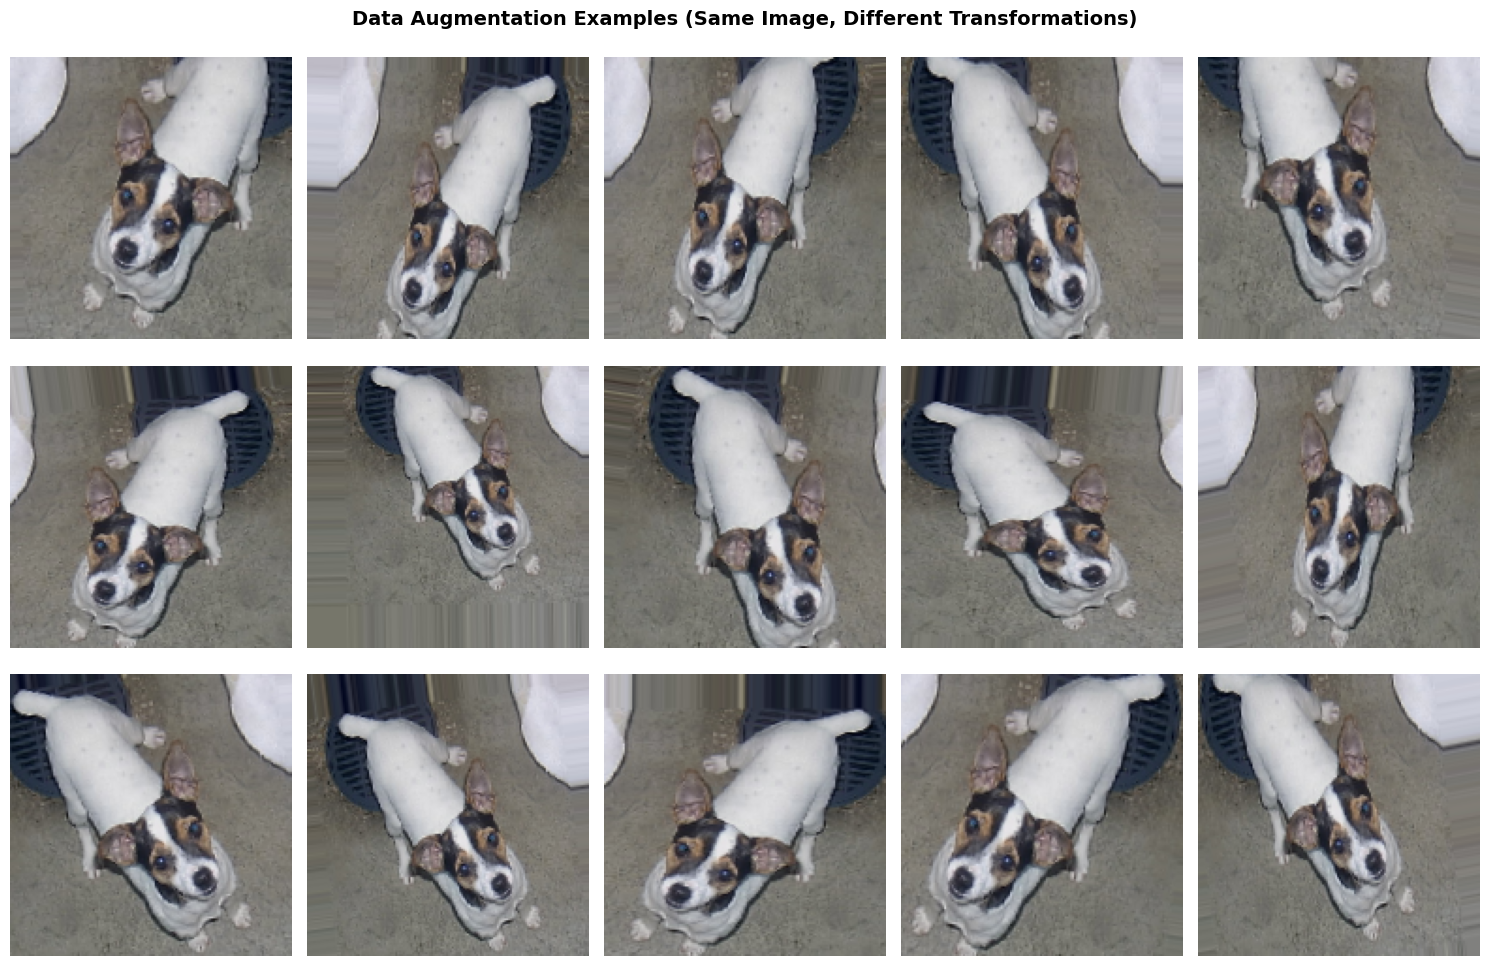

In [151]:
example_df = train_df.sample(n=1, random_state=RANDOM_SEED).reset_index(drop=True)

example_generator = train_datagen.flow_from_dataframe(
    example_df,
    BASE_PATH,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

plt.figure(figsize=(15, 10))
for i in range(15):
    plt.subplot(3, 5, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        plt.axis('off')
        break

plt.suptitle('Data Augmentation Examples (Same Image, Different Transformations)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

##  7. Build CNN Model

**Architecture Overview:**

Our CNN consists of:
- **3 Convolutional Blocks** (32 → 64 → 128 filters)
- **Batch Normalization** after each convolution (improves training stability)
- **MaxPooling** for downsampling
- **Dropout** for regularization (prevents overfitting)
- **Dense layer** with 512 units
- **Softmax output** for binary classification

**Why these choices?**
- Increasing filters (32→64→128) captures progressively complex features
- BatchNorm stabilizes training and allows higher learning rates
- Dropout (0.2, 0.2, 0.3, 0.5) prevents overfitting
- ReLU activation adds non-linearity

In [152]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', 
           input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),
    
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),
    
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(2, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

print("✓ Model built successfully!")
print("\nModel Architecture:")
model.summary()

✓ Model built successfully!

Model Architecture:


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 512)            │    21,234,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,331,394 (81.37 MB)

 Trainable params: 21,329,922 (81.37 MB)

 Non-trainable params: 1,472 (5.75 KB)

##  8. Setup Callbacks

**Callbacks** are functions that run during training to improve performance:

### Early Stopping
- Monitors validation loss
- Stops training if no improvement for 10 epochs
- Restores best weights automatically
- **Prevents overfitting!**

### ReduceLROnPlateau
- Monitors validation accuracy
- Reduces learning rate by 50% if plateaus for 3 epochs
- Helps fine-tune the model in later epochs
- Minimum LR: 0.0001

In [153]:
earlystop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=3,
    verbose=1,
    factor=0.5,
    min_lr=0.0001
)

callbacks = [earlystop, learning_rate_reduction]

print("Callbacks configured!")

Callbacks configured!


##  9. Train the Model

**Training Process:**
- Epochs: 20 (may stop earlier due to early stopping)
- Batch size: 128
- Steps per epoch: Calculated based on dataset size

**What to watch:**
- Training accuracy should increase steadily
- Validation accuracy should follow training accuracy
- If val_acc stops improving, callbacks will kick in

**Expected time:** ~10-15 minutes (depends on GPU/CPU)

---

 **Grab a coffee while the model trains!**

In [154]:
print("Starting training...\n" + "="*60)

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validate_df) // BATCH_SIZE,
    steps_per_epoch=len(train_df) // BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

print("\n" + "="*60)
print("Training completed!")

Starting training...
Epoch 1/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 148s 950ms/step - accuracy: 0.6090 - loss: 1.0183 - val_accuracy: 0.4978 - val_loss: 4.3112 - learning_rate: 0.0010
Epoch 2/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.5703 - loss: 0.7346 - val_accuracy: 0.4991 - val_loss: 4.3997 - learning_rate: 0.0010
Epoch 3/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 132s 898ms/step - accuracy: 0.7189 - loss: 0.5757 - val_accuracy: 0.5200 - val_loss: 2.3023 - learning_rate: 0.0010
Epoch 4/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.7656 - loss: 0.4905 - val_accuracy: 0.5230 - val_loss: 2.2384 - learning_rate: 0.0010
Epoch 5/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 135s 914ms/step - accuracy: 0.7488 - loss: 0.5046 - val_accuracy: 0.5503 - val_loss: 1.0670 - learning_rate: 0.0010
Epoch 6/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.7812 - loss: 0.5732 - val_accuracy: 0.5516 - val_loss: 1.0215 - learning_rate: 0.0010
Epoch 7/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 133s 907ms/s

##  10. Save Model

Saving the trained model weights so we can use them later without retraining.

In [155]:
model.save_weights(MODEL_SAVE_PATH)
print(f" Model weights saved to: {MODEL_SAVE_PATH}")

 Model weights saved to: model.weights.h5


## 11. Visualize Training History

Let's plot the training curves to understand how our model learned:

**What to look for:**
- **Loss curve**: Should decrease over time (lower is better)
- **Accuracy curve**: Should increase over time (higher is better)
- **Gap between train/val**: Small gap = good generalization, Large gap = overfitting

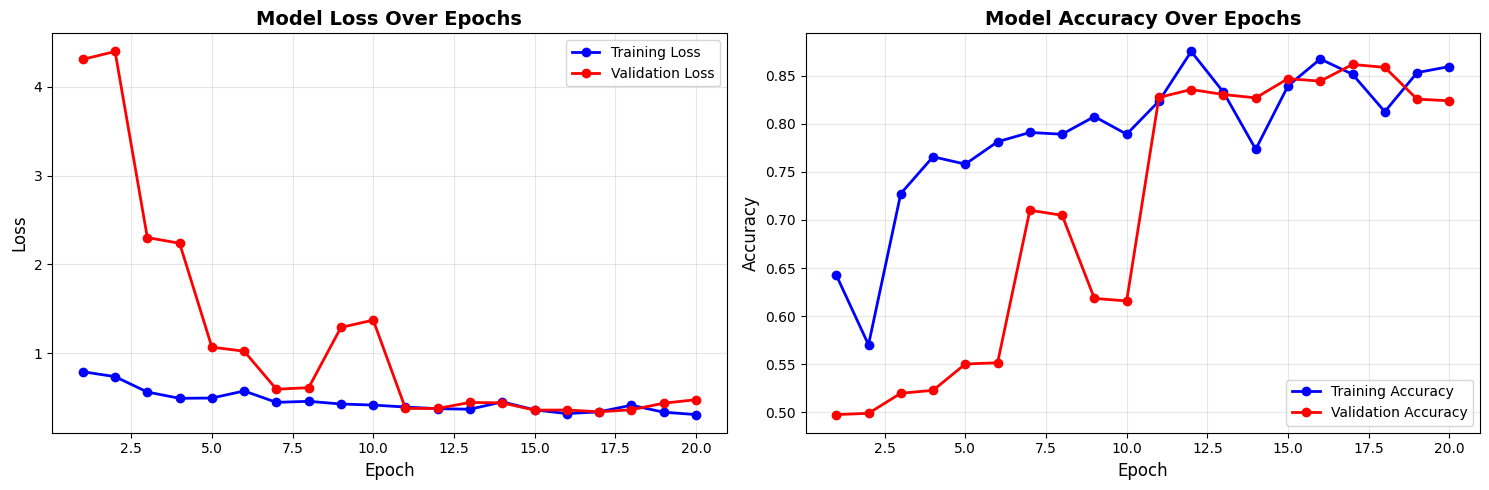

 Training history plot saved!


In [164]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

epochs_range = range(1, len(history.history['loss']) + 1)

ax1.plot(epochs_range, history.history['loss'], 'b-o', label='Training Loss', linewidth=2)
ax1.plot(epochs_range, history.history['val_loss'], 'r-o', label='Validation Loss', linewidth=2)
ax1.set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

ax2.plot(epochs_range, history.history['accuracy'], 'b-o', label='Training Accuracy', linewidth=2)
ax2.plot(epochs_range, history.history['val_accuracy'], 'r-o', label='Validation Accuracy', linewidth=2)
ax2.set_title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.legend(loc='lower right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Training history plot saved!")

### 11.1 Final Training Metrics

In [165]:
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(f"Final Training Accuracy: {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
print(f"Final Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")
print(f"\nOverfitting Check: {abs(final_train_acc - final_val_acc):.4f}")
print(" Good!" if abs(final_train_acc - final_val_acc) < 0.05 else "Model may be overfitting")

Final Training Accuracy: 0.8594 (85.94%)
Final Validation Accuracy: 0.8238 (82.38%)

Overfitting Check: 0.0356
 Good!


## 12. Evaluate on Test Set

Now let's see how the model performs on completely unseen data (test set).

**Remember:** The model has NEVER seen these images during training!

In [166]:
test_gen = ImageDataGenerator(rescale=1./255)

test_generator = test_gen.flow_from_dataframe(
    test_df,
    BASE_PATH,
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print("Generating predictions on test set...")
steps = int(np.ceil(len(test_df) / BATCH_SIZE))
predictions = model.predict(test_generator, steps=steps, verbose=1)

test_df['pred_category'] = np.argmax(predictions, axis=-1).astype(str)
test_df['confidence'] = np.max(predictions, axis=-1)

print("\n Predictions generated!")
print("\nSample predictions:")
print(test_df[['filename', 'category', 'pred_category', 'confidence']].head(10))

Found 3750 validated image filenames.
Generating predictions on test set...
30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 538ms/step

 Predictions generated!

Sample predictions:
        filename category pred_category  confidence
0   Cat/6526.jpg        1             1    0.822060
1   Cat/1323.jpg        1             1    0.895928
2   Cat/8910.jpg        1             1    0.709232
3   Cat/3186.jpg        1             0    0.526693
4  Dog/10368.jpg        0             0    0.976280
5   Dog/1273.jpg        0             0    0.989352
6   Cat/8075.jpg        1             1    0.988903
7  Cat/11729.jpg        1             1    0.988129
8   Dog/3612.jpg        0             0    0.956583
9   Cat/6606.jpg        1             1    0.837743


## 13. Classification Metrics

Let's calculate comprehensive performance metrics:
- **Accuracy**: Overall correctness
- **Precision**: When model predicts positive, how often is it correct?
- **Recall**: How many actual positives did we catch?
- **F1-Score**: Harmonic mean of precision and recall

In [167]:
test_accuracy = accuracy_score(test_df['category'], test_df['pred_category'])

print("="*60)
print(f"{'TEST SET PERFORMANCE':^60}")
print("="*60)
print(f"\nOverall Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print("\n" + "-"*60)

print("\nDetailed Classification Report:")
print("-"*60)
print(classification_report(
    test_df['category'], 
    test_df['pred_category'],
    target_names=['Dog', 'Cat'],
    digits=4
))
print("="*60)

                    TEST SET PERFORMANCE                    

Overall Test Accuracy: 0.8592 (85.92%)

------------------------------------------------------------

Detailed Classification Report:
------------------------------------------------------------
              precision    recall  f1-score   support

         Dog     0.8846    0.8261    0.8544      1875
         Cat     0.8369    0.8923    0.8637      1875

    accuracy                         0.8592      3750
   macro avg     0.8608    0.8592    0.8590      3750
weighted avg     0.8608    0.8592    0.8590      3750



##  14. Confusion Matrix

The confusion matrix shows:
- **True Positives (TP)**: Correctly predicted cats as cats
- **True Negatives (TN)**: Correctly predicted dogs as dogs
- **False Positives (FP)**: Incorrectly predicted dogs as cats
- **False Negatives (FN)**: Incorrectly predicted cats as dogs

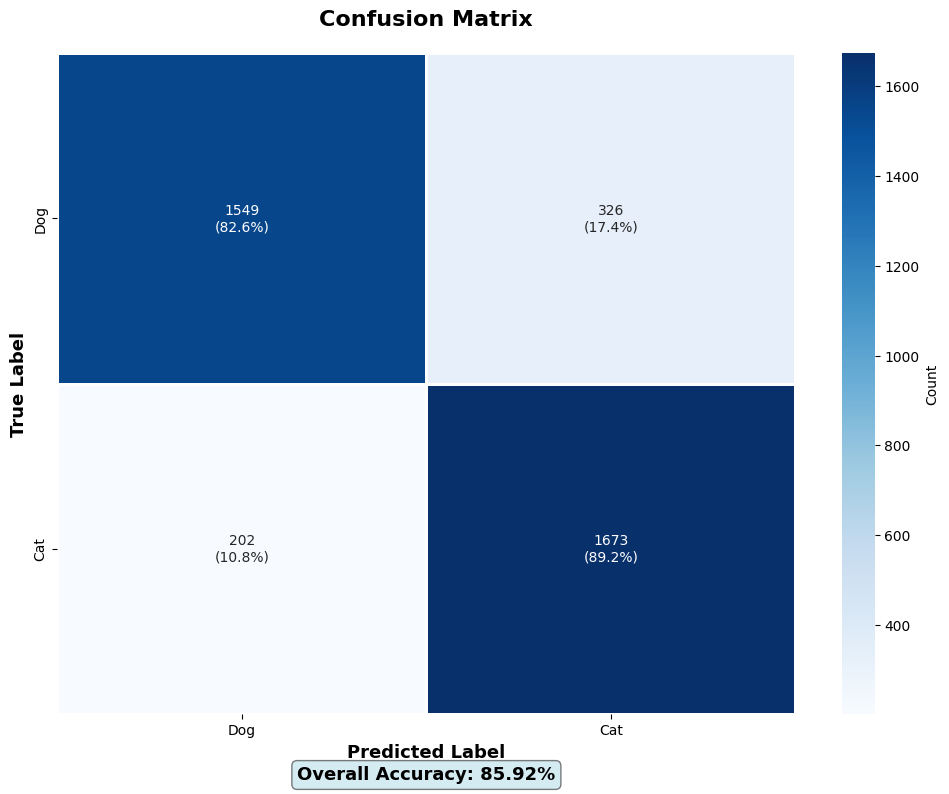

 Confusion matrix saved!


In [168]:
cm = confusion_matrix(test_df['category'], test_df['pred_category'])
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

annotations = np.array([[f'{count}\n({percent:.1f}%)' 
                        for count, percent in zip(row_counts, row_percents)]
                       for row_counts, row_percents in zip(cm, cm_percent)])

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=annotations, fmt='', cmap='Blues',
            xticklabels=['Dog', 'Cat'],
            yticklabels=['Dog', 'Cat'],
            cbar_kws={'label': 'Count'},
            linewidths=2, linecolor='white')

plt.title('Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=13, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=13, fontweight='bold')

accuracy = np.trace(cm) / np.sum(cm)
plt.text(0.5, -0.1, f'Overall Accuracy: {accuracy:.2%}',
         ha='center', transform=plt.gca().transAxes,
         fontsize=13, fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Confusion matrix saved!")

## 15. Visualize Predictions



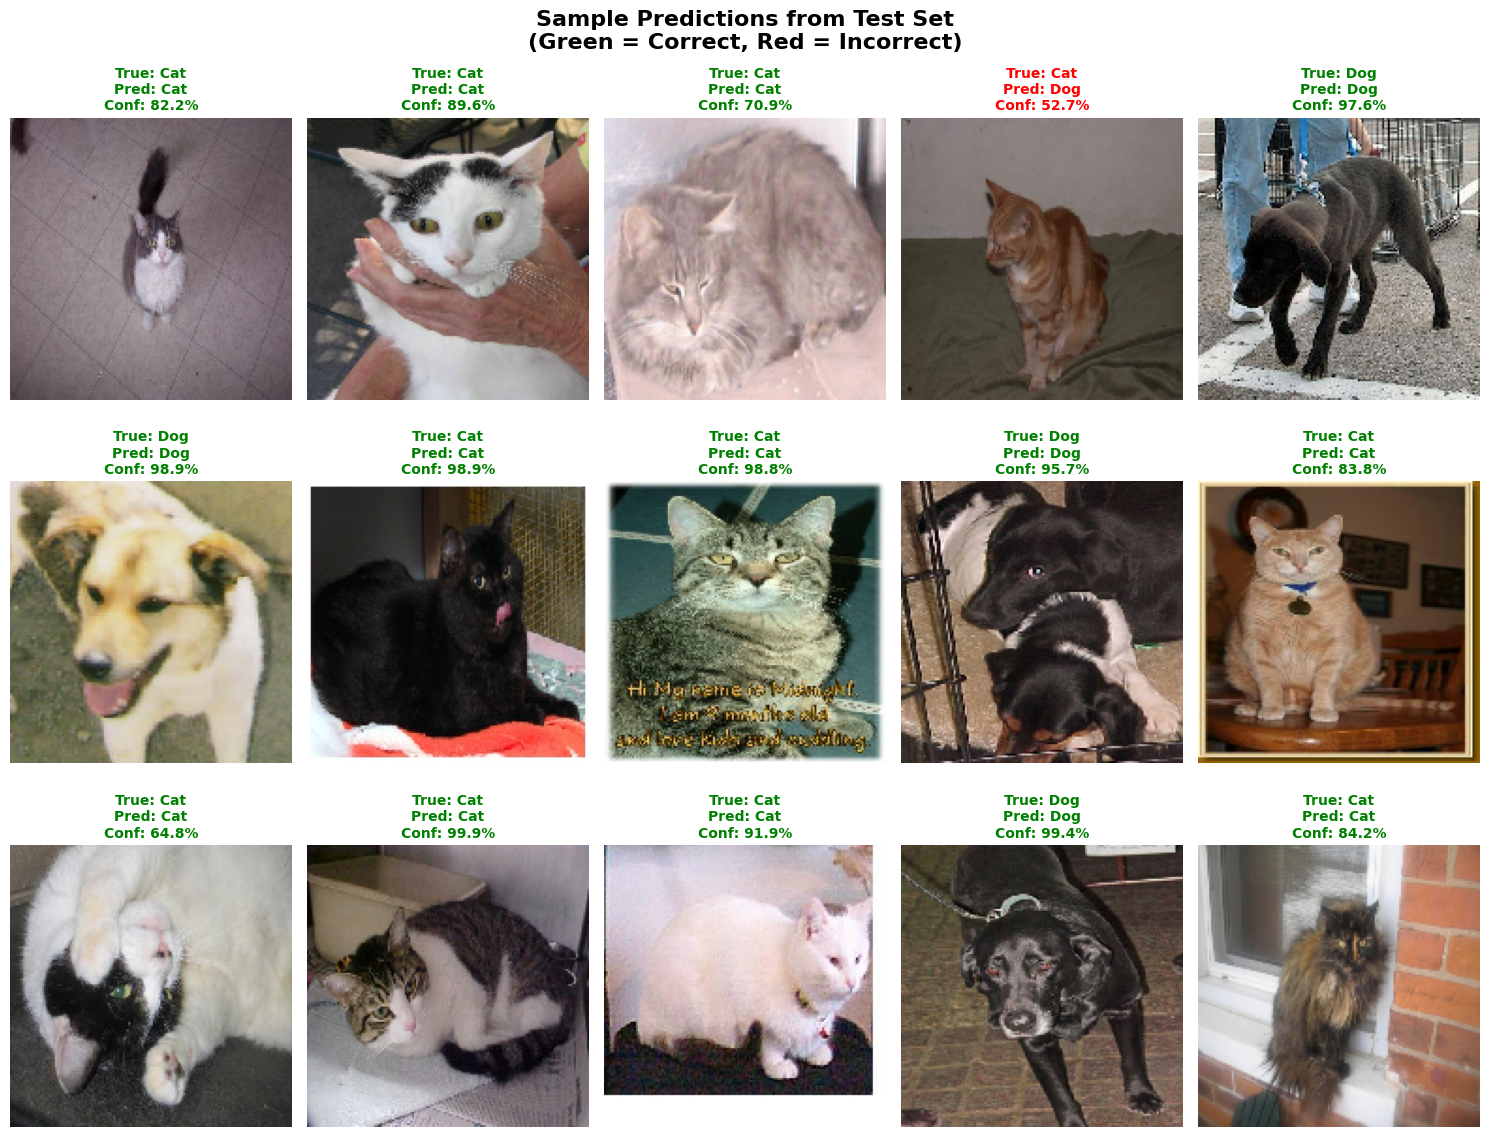

Sample predictions saved!


In [169]:
sample_test = test_df.head(15)

plt.figure(figsize=(15, 12))

for idx, (index, row) in enumerate(sample_test.iterrows(), 1):
    filename = row['filename']
    true_label = 'Cat' if row['category'] == '1' else 'Dog'
    pred_label = 'Cat' if row['pred_category'] == '1' else 'Dog'
    confidence = row['confidence'] * 100
    
    img_path = os.path.join(BASE_PATH, filename)
    img = load_img(img_path, target_size=IMAGE_SIZE)
    
    plt.subplot(3, 5, idx)
    plt.imshow(img)
    
    color = 'green' if true_label == pred_label else 'red'
    title = f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.1f}%'
    
    plt.title(title, fontsize=10, fontweight='bold', color=color)
    plt.axis('off')

plt.suptitle('Sample Predictions from Test Set\n(Green = Correct, Red = Incorrect)', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('sample_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

print("Sample predictions saved!")

##  16. Deploy with Gradio (Optional)

Create an interactive web interface where you can upload images and get instant predictions!

**Uncomment and run the cell below to launch the interface.**

In [173]:
!pip install gradio -q

In [174]:
import gradio as gr

def predict_image(img):
    """
    Predict if an image is a dog or cat.
    
    Args:
        img: PIL Image object
        
    Returns:
        dict: Probabilities for each class
    """
    img_resized = img.resize(IMAGE_SIZE)
    img_array = img_to_array(img_resized)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    prediction = model.predict(img_array, verbose=0)[0]
    
    labels = ['Dog 🐶', 'Cat 🐱']
    return {labels[i]: float(prediction[i]) for i in range(2)}

interface = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="pil", label="Upload Pet Image"),
    outputs=gr.Label(num_top_classes=2, label="Prediction"),
    title="🐾 Dog vs. Cat Classifier",
    description=f"""
    Upload an image of a dog or cat, and the AI will classify it!
    
    **Model Performance:**
    - Test Accuracy: {test_accuracy:.2%}
    - Architecture: Custom CNN with BatchNormalization
    - Training Dataset: 25,000 images
    """
)

# Launch (uncomment to run)
interface.launch(share=True)

* Running on local URL:  http://127.0.0.1:7865
* Running on public URL: https://6ab0ba676e0c269fb4.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/fastapi/applications.py", line 1139, in __call__
    await super().__call__(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/applications.py", line 107, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py", line 186, in __call__
    raise exc
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py",